In [1]:
import os,glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from random import randint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback,EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from sklearn.metrics import classification_report
import numpy as np
from os import path, listdir
from skimage.io import imread,imshow,imsave

In [2]:
root_path = '../Python/AGAR_species'

name_class = os.listdir(root_path)
name_class

['B.subtilis', 'C.albicans', 'E.coli', 'P.aeruginosa', 'S.aureus']

In [3]:
dataset_Path = list(glob.glob(root_path+'/**/*.*'))

In [4]:
labels = list(map(lambda x : os.path.split(os.path.split(x)[0])[1],dataset_Path))


In [5]:
dataset_Path = pd.Series(dataset_Path,name = 'FilePath').astype(str)
labels = pd.Series(labels,name='Label')
data = pd.concat([dataset_Path,labels],axis =1)
data = data.sample(frac=1).reset_index(drop= True)
data.head(5)

,FilePath,Label
0,../Python/AGAR_species\E.coli\15978.jpg,E.coli
1,../Python/AGAR_species\C.albicans\13398.jpg,C.albicans
2,../Python/AGAR_species\B.subtilis\727.jpg,B.subtilis
3,../Python/AGAR_species\E.coli\13551.jpg,E.coli
4,../Python/AGAR_species\C.albicans\15670.jpg,C.albicans


(2048, 2048, 3)

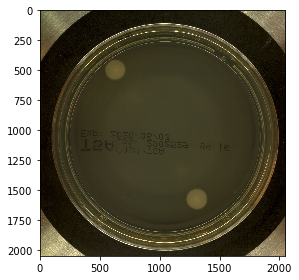

In [27]:
img = imread('AGAR_species/E.coli/13005.jpg')
imshow(img)
img.shape

In [28]:
train,rem = train_test_split(data,test_size =0.20,random_state = 42 )
test,valid = train_test_split(data,test_size =0.50,random_state = 42 )

In [29]:
train
train.shape

(1613, 2)

In [30]:
test
test.shape

(1008, 2)

In [31]:
valid

,FilePath,Label
1555,../Python/AGAR_species\C.albicans\14265.jpg,C.albicans
526,../Python/AGAR_species\S.aureus\15084.jpg,S.aureus
393,../Python/AGAR_species\B.subtilis\14813.jpg,B.subtilis
1788,../Python/AGAR_species\C.albicans\13587.jpg,C.albicans
433,../Python/AGAR_species\P.aeruginosa\13620.jpg,P.aeruginosa
...,...,...
25,../Python/AGAR_species\P.aeruginosa\15033.jpg,P.aeruginosa
1874,../Python/AGAR_species\B.subtilis\1165.jpg,B.subtilis
714,../Python/AGAR_species\C.albicans\13079.jpg,C.albicans
1018,../Python/AGAR_species\S.aureus\13354.jpg,S.aureus


In [32]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i]-10,y[i], ha = 'center')

In [33]:
counts = data.Label.value_counts()

Text(0, 0.5, 'label')

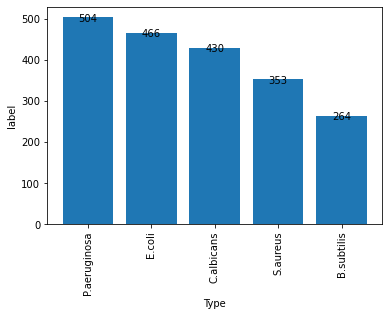

In [34]:
plt.bar(counts.index, counts)
addlabels(counts.index, counts)
plt.xticks(rotation=90)
plt.xlabel('Type')
plt.ylabel('label')

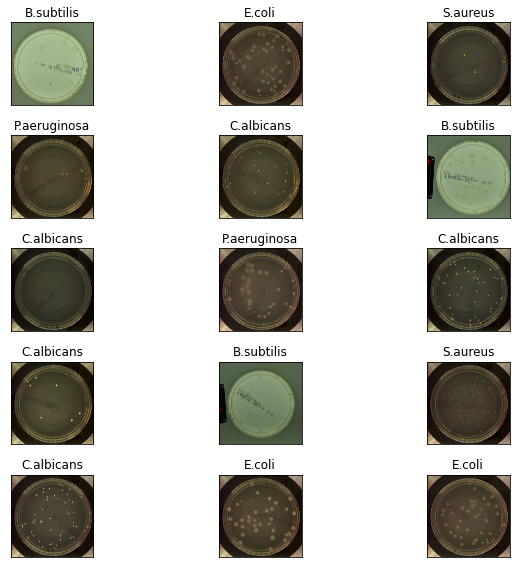

In [35]:
fig,axes = plt.subplots(nrows=5,ncols=3,figsize=(10,8),subplot_kw={'xticks':[],'yticks':[]})
for i ,ax,in enumerate(axes.flat):
  ax.imshow(plt.imread(data.FilePath[i]))
  ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [36]:
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=10,
)
test_datagen = ImageDataGenerator()

In [37]:
train_gen = train_datagen.flow_from_dataframe(dataframe = train,x_col = 'FilePath',y_col = 'Label',target_size=(224,224),
                                              class_mode ='categorical', color_mode='rgb',batch_size =8,shuffle = True,seed =42)
valid_gen = train_datagen.flow_from_dataframe(dataframe = valid,x_col = 'FilePath',y_col = 'Label',target_size=(224,224),
                                              class_mode ='categorical', color_mode='rgb',batch_size =8,shuffle = False,seed =42)
test_gen =  test_datagen.flow_from_dataframe(dataframe = test,x_col = 'FilePath',y_col = 'Label',target_size=(224,224),
                                             class_mode ='categorical', color_mode='rgb',batch_size =8,shuffle = False,seed =42)

Found 1613 validated image filenames belonging to 5 classes.
Found 1009 validated image filenames belonging to 5 classes.
Found 1008 validated image filenames belonging to 5 classes.


# VGG-16 Architecture

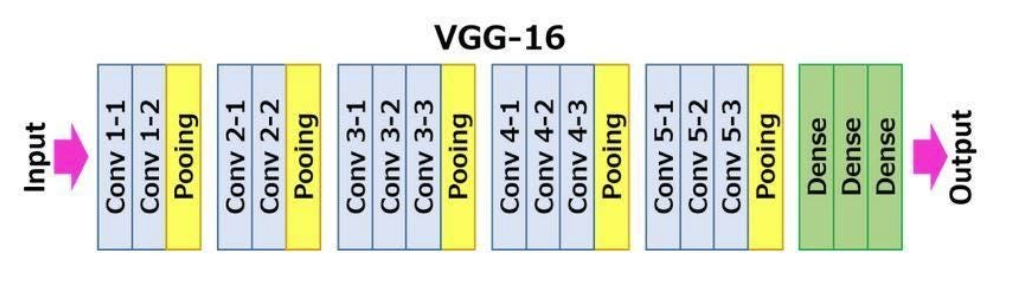

In [38]:
NO_CLASSES = max(train_gen.class_indices.values()) + 1
base_model = VGG16(include_top=False, input_shape=(2048, 2048, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x) #used to replace fully connected layers in classical CNNs.
#It will generate one feature map for each corresponding category of the classification task in the last mlpcov layer(1 X 1 convolutions).
x = Dense(1024,activation='relu')(x)   # add dense layers so learn more complex functions and classify for better results.    
x = Dense(1024,activation='relu')(x)   # dense layer 2
x = Dense(512,activation='relu')(x)    # dense layer 3

preds = Dense(NO_CLASSES,activation='softmax')(x) 
model = Model(inputs = base_model.input, outputs = preds) #create a new model with the base model's original input 

In [39]:
for layer in model.layers[:19]:
    layer.trainable=False
#train the rest of the layers
for layer in model.layers[19:]:
    layer.trainable=True

In [40]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [42]:
model.fit(train_gen,validation_data = valid_gen,
          epochs=10)

Epoch 1/10
202/202 [==============================] - 778s 4s/step - loss: 2.0837 - accuracy: 0.5336 - val_loss: 0.7218 - val_accuracy: 0.6898
Epoch 2/10
202/202 [==============================] - 519s 3s/step - loss: 0.6947 - accuracy: 0.7027 - val_loss: 0.4433 - val_accuracy: 0.8454
Epoch 3/10
202/202 [==============================] - 452s 2s/step - loss: 0.5798 - accuracy: 0.7570 - val_loss: 0.4212 - val_accuracy: 0.8127
Epoch 4/10
202/202 [==============================] - 454s 2s/step - loss: 0.4651 - accuracy: 0.8143 - val_loss: 0.4988 - val_accuracy: 0.7998
Epoch 5/10
202/202 [==============================] - 458s 2s/step - loss: 0.4290 - accuracy: 0.8326 - val_loss: 0.5808 - val_accuracy: 0.7849
Epoch 6/10
202/202 [==============================] - 459s 2s/step - loss: 0.4375 - accuracy: 0.8282 - val_loss: 0.4410 - val_accuracy: 0.8176
Epoch 7/10
202/202 [==============================] - 460s 2s/step - loss: 0.3878 - accuracy: 0.8542 - val_loss: 0.3424 - val_accuracy: 0.8652

In [43]:
model.evaluate(test_gen)

126/126 [==============================] - 158s 1s/step - loss: 0.4515 - accuracy: 0.8175


[0.451507031917572, 0.817460298538208]

In [44]:
pred = model.predict(test_gen) 
pred = np.argmax(pred,axis=1)
labels = (train_gen.class_indices) 
labels = dict((v,k) for k,v, in labels.items()) #
pred = [labels[k]for k in pred]

In [45]:
y_test = list(test.Label)
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

  B.subtilis       1.00      0.96      0.98       128
  C.albicans       0.83      0.99      0.90       221
      E.coli       0.97      0.59      0.73       244
P.aeruginosa       0.71      0.73      0.72       248
    S.aureus       0.72      0.93      0.81       167

    accuracy                           0.82      1008
   macro avg       0.85      0.84      0.83      1008
weighted avg       0.84      0.82      0.81      1008



In [46]:
labels = (train_gen.class_indices)